[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ruban\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruban\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(100000, 4)
   ENTITY_ID  CATEGORY_ID  ENTITY_LENGTH   
0     216064          112     600.000000  \
1    2498090         8360     984.251967   
2     210860           30     850.000000   
3     285757         6104     744.000000   
4    1869643         2201     600.000000   

                                  ENTITY_DESCRIPTION  
0                               Caricaturas (1892)    
1  VJ Interior Modern Solid Interio Cushioned Bar...  
2  Pam: Personalized Name Journal with Blank Line...  
3  Hio Nya Testamenti Drottins Vors Jesu Krists A...  
4  ADDIT Phone Case for Samsung Galaxy A50 [ Mili...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ENTITY_ID           100000 non-null  int64  
 1   CATEGORY_ID         100000 non-null  int64  
 2   ENTITY_LENGTH       100000 non-null  float64
 3   ENTITY_DESCRIPTION  100000 no

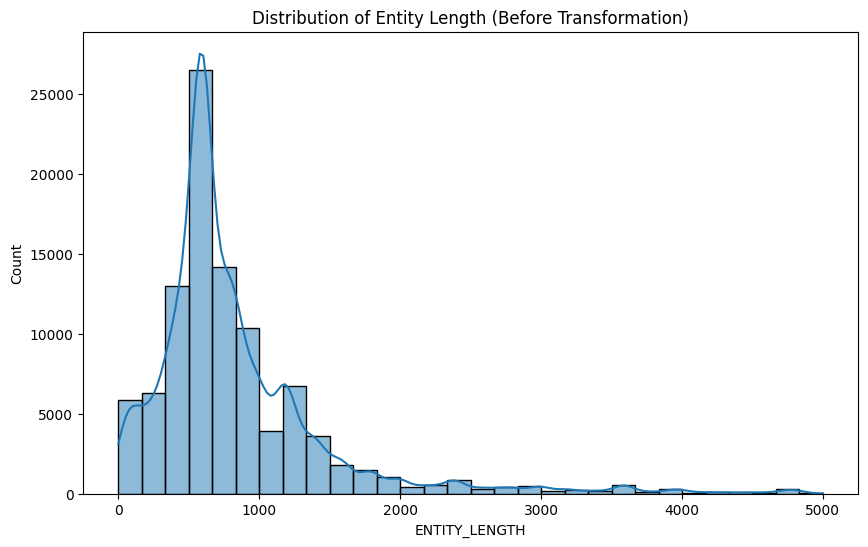

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Download NLTK data (only needs to be done once)
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopwords

# Load the dataset
data = pd.read_csv("C:\\Users\\ruban\\Downloads\\Login\\Train.csv")
test_data = pd.read_csv("C:\\Users\\ruban\\Downloads\\Login\\Test.csv")

# Step 1: Understand the Structure of the Data
print(data.shape)
print(data.head())
print(data.info())

# Step 2: Check for Missing Values
print(data.isnull().sum())

# Step 3: Plot the Distribution of ENTITY_LENGTH before any transformation
plt.figure(figsize=(10, 6))
sns.histplot(data['ENTITY_LENGTH'], bins=30, kde=True)
plt.title('Distribution of Entity Length (Before Transformation)')
plt.show()


Lambda used for Box-Cox transformation: 0.4987489982344055


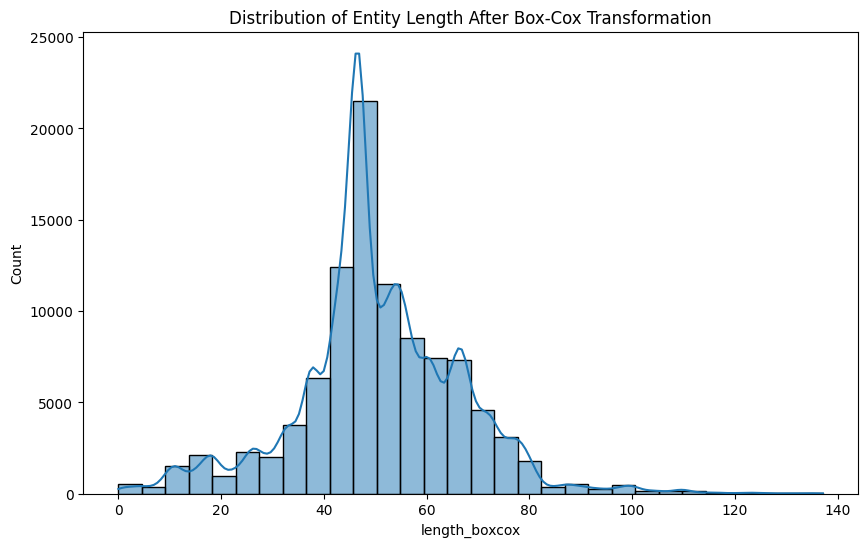

Skewness of length_boxcox: 0.1165718217513661


In [4]:
# Step 4: Handle Outliers Using IQR Method (optional if needed)
Q1 = data['ENTITY_LENGTH'].quantile(0.25)
Q3 = data['ENTITY_LENGTH'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_mask = (data['ENTITY_LENGTH'] < lower_bound) | (data['ENTITY_LENGTH'] > upper_bound)
mean_lengths = data.groupby('CATEGORY_ID')['ENTITY_LENGTH'].mean()
data.loc[outlier_mask, 'ENTITY_LENGTH'] = data.loc[outlier_mask, 'CATEGORY_ID'].map(mean_lengths)

# Step 5: Box-Cox Transformation
# Ensure no zero or negative values, adding a small constant (1e-3) to avoid issues
data['ENTITY_LENGTH'] = data['ENTITY_LENGTH'].replace(0, 1e-3)

# Apply Box-Cox transformation
data['length_boxcox'], fitted_lambda = stats.boxcox(data['ENTITY_LENGTH'])
print(f'Lambda used for Box-Cox transformation: {fitted_lambda}')

# Step 6: Visualize the Distribution after Box-Cox Transformation
plt.figure(figsize=(10, 6))
sns.histplot(data['length_boxcox'], bins=30, kde=True)
plt.title('Distribution of Entity Length After Box-Cox Transformation')
plt.show()

# Step 7: Check skewness after transformation
skewness_boxcox = pd.Series(data['length_boxcox']).skew()
print(f'Skewness of length_boxcox: {skewness_boxcox}')

# Step 8: Preprocess TEXT data (lowercase, punctuation removal, tokenization, stopword removal, stemming)
data['ENTITY_DESCRIPTION'] = data['ENTITY_DESCRIPTION'].str.lower()
data['ENTITY_DESCRIPTION'] = data['ENTITY_DESCRIPTION'].str.replace('[^\w\s]', '', regex=True)
data['tokens'] = data['ENTITY_DESCRIPTION'].apply(word_tokenize)
stop_words = set(stopwords.words('english'))
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
stemmer = PorterStemmer()
data['tokens'] = data['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

Shape of TF-IDF matrix: (100000, 10000)
Train-Validation Split: (80000, 4) (20000, 4) (80000,) (20000,)


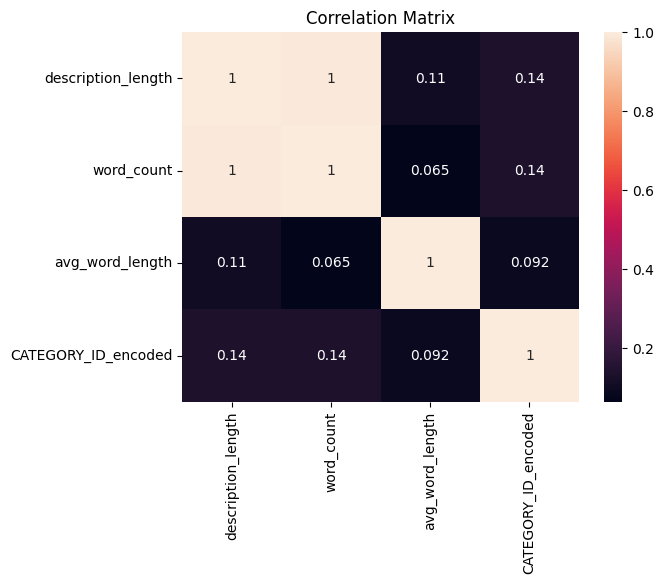

In [5]:
# Step 9: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, min_df=5)
X_text = tfidf.fit_transform(data['ENTITY_DESCRIPTION'])
print("Shape of TF-IDF matrix:", X_text.shape)

# Step 10: Feature Engineering: Adding text length features
data['description_length'] = data['ENTITY_DESCRIPTION'].apply(len)
data['word_count'] = data['ENTITY_DESCRIPTION'].apply(lambda x: len(x.split()))
data['avg_word_length'] = data['description_length'] / (data['word_count'] + 1)

# Step 11: Target Encoding for CATEGORY_ID
# Calculate the mean ENTITY_LENGTH for each CATEGORY_ID
mean_lengths = data.groupby('CATEGORY_ID')['ENTITY_LENGTH'].mean()

# Map the mean length back to the original dataframe as encoded CATEGORY_ID
data['CATEGORY_ID_encoded'] = data['CATEGORY_ID'].map(mean_lengths)

# Step 12: Scaling numerical features
scaler = StandardScaler()
num_features = ['description_length', 'word_count', 'avg_word_length', 'CATEGORY_ID_encoded']  # Include encoded CATEGORY_ID
data[num_features] = scaler.fit_transform(data[num_features])

# Step 13: Train-test split
# Note: We drop 'length_boxcox' from the training features
X = data.drop(columns=['ENTITY_LENGTH', 'ENTITY_ID', 'CATEGORY_ID', 'ENTITY_DESCRIPTION', 'tokens', 'length_boxcox'])
y = data['length_boxcox']  # Use the Box-Cox transformed target variable

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train-Validation Split:", X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Step 14: Check for multicollinearity
corr_matrix = data[num_features].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [6]:
# --- Step 3: Build Models ---

# Model 1: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_val)

# Model 2: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

# Model 3: XGBoost
xgboost_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_val)

# --- Step 4: Evaluate Models ---

# Ensure no NaN values in predictions
y_pred_linear = np.nan_to_num(y_pred_linear, nan=0.0)
y_pred_rf = np.nan_to_num(y_pred_rf, nan=0.0)
y_pred_xgb = np.nan_to_num(y_pred_xgb, nan=0.0)

# Check for NaN values in actual target
y_val = np.nan_to_num(y_val, nan=0.0)


In [11]:
# Evaluate with MAPE
mape_linear = mean_absolute_percentage_error(y_val, y_pred_linear)
mape_rf = mean_absolute_percentage_error(y_val, y_pred_rf)
mape_xgb = mean_absolute_percentage_error(y_val, y_pred_xgb)

print(f"MAPE - Linear Regression: {mape_linear}")
print(f"MAPE - Random Forest: {mape_rf}")
print(f"MAPE - XGBoost: {mape_xgb}")

# --- Step 5: Prepare the Test Set ---

# Apply the same transformations to the test set
test_data['ENTITY_DESCRIPTION'] = test_data['ENTITY_DESCRIPTION'].str.lower()
test_data['ENTITY_DESCRIPTION'] = test_data['ENTITY_DESCRIPTION'].str.replace('[^\w\s]', '', regex=True)
test_data['description_length'] = test_data['ENTITY_DESCRIPTION'].apply(len)
test_data['word_count'] = test_data['ENTITY_DESCRIPTION'].apply(lambda x: len(x.split()))
test_data['avg_word_length'] = test_data['description_length'] / (test_data['word_count'] + 1)
test_data['CATEGORY_ID_encoded'] = test_data['CATEGORY_ID'].map(mean_lengths)
test_data[num_features] = scaler.transform(test_data[num_features])

X_test = test_data[num_features]

# --- Step 6: Generate Predictions on the Test Set ---
y_test_pred_xgb = xgboost_model.predict(X_test)

# Ensure no NaN in predictions
y_test_pred_xgb = np.nan_to_num(y_test_pred_xgb, nan=0.0)
y_pred_linear = np.nan_to_num(y_pred_linear, nan=0.0)
y_pred_rf = np.nan_to_num(y_pred_rf, nan=0.0)

# --- Step 7: Generate Submission File ---
submission = pd.DataFrame({'ENTITY_ID': test_data['ENTITY_ID'], 'ENTITY_LENGTH': y_test_pred_xgb})
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")

submission1 = pd.DataFrame({'ENTITY_ID': test_data['ENTITY_ID'], 'ENTITY_LENGTH': y_pred_linear})
submission1.to_csv('submission1.csv', index=False)

print("Submission file created successfully.")

submission2 = pd.DataFrame({'ENTITY_ID': test_data['ENTITY_ID'], 'ENTITY_LENGTH': y_pred_rf})
submission2.to_csv('submission2.csv', index=False)

print("Submission file created successfully.")

MAPE - Linear Regression: 112847829986148.45
MAPE - Random Forest: 97100246305293.66
MAPE - XGBoost: 107580817571578.25
Submission file created successfully.
Submission file created successfully.
Submission file created successfully.


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Step 4: Evaluate Models ---

# Ensure no NaN values in predictions
y_pred_linear = np.nan_to_num(y_pred_linear, nan=0.0)
y_pred_rf = np.nan_to_num(y_pred_rf, nan=0.0)
y_pred_xgb = np.nan_to_num(y_pred_xgb, nan=0.0)

# Check for NaN values in actual target
y_val = np.nan_to_num(y_val, nan=0.0)

# Evaluate with MAPE
mape_linear = mean_absolute_percentage_error(y_val, y_pred_linear)
mape_rf = mean_absolute_percentage_error(y_val, y_pred_rf)
mape_xgb = mean_absolute_percentage_error(y_val, y_pred_xgb)

# Evaluate with additional metrics

# Mean Absolute Error (MAE)
mae_linear = mean_absolute_error(y_val, y_pred_linear)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

# Mean Squared Error (MSE)
mse_linear = mean_squared_error(y_val, y_pred_linear)
mse_rf = mean_squared_error(y_val, y_pred_rf)
mse_xgb = mean_squared_error(y_val, y_pred_xgb)

# Root Mean Squared Error (RMSE)
rmse_linear = np.sqrt(mse_linear)
rmse_rf = np.sqrt(mse_rf)
rmse_xgb = np.sqrt(mse_xgb)

# R-squared (R2 Score)
r2_linear = r2_score(y_val, y_pred_linear)
r2_rf = r2_score(y_val, y_pred_rf)
r2_xgb = r2_score(y_val, y_pred_xgb)

# Ensure there are no zero values in y_val or y_pred before calculating MAPE
non_zero_indices = y_val != 0
mape_linear = mean_absolute_percentage_error(y_val[non_zero_indices], y_pred_linear[non_zero_indices])
mape_rf = mean_absolute_percentage_error(y_val[non_zero_indices], y_pred_rf[non_zero_indices])
mape_xgb = mean_absolute_percentage_error(y_val[non_zero_indices], y_pred_xgb[non_zero_indices])

print(f"MAPE - Linear Regression : {mape_linear}")
print(f"MAPE - Random Forest : {mape_rf}")
print(f"MAPE - XGBoost : {mape_xgb}")


# Print all metrics
print(f"--- Linear Regression ---")
print(f"MAE: {mae_linear}")
print(f"MSE: {mse_linear}")
print(f"RMSE: {rmse_linear}")
print(f"R-squared: {r2_linear}")

print(f"--- Random Forest ---")
print(f"MAE: {mae_rf}")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R-squared: {r2_rf}")

print(f"--- XGBoost ---")

print(f"MAE: {mae_xgb}")
print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"R-squared: {r2_xgb}")


MAPE - Linear Regression (after removing zeros): 0.4134711341110337
MAPE - Random Forest (after removing zeros): 0.3790645977540483
MAPE - XGBoost (after removing zeros): 0.3943424787156064
--- Linear Regression ---
MAE: 8.940768863141138
MSE: 160.8012274503719
RMSE: 12.680742385616542
R-squared: 0.39269630395432775
--- Random Forest ---
MAE: 8.884755572729254
MSE: 163.72444328756262
RMSE: 12.7954852697177
R-squared: 0.38165609107527443
--- XGBoost ---
MAE: 8.666536818194981
MSE: 154.13613147438608
RMSE: 12.4151573278145
R-squared: 0.4178686082015983
